# Step 4. Analyses and visualizations 
inputs: 
- `preprocessed_merfish_ad_mouse_rotated.hdf5`
- `clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_...tsv.gz`
- `palette_admouse.json`

outputs:
- cluster visualizations
- gene level analyses

In [2]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import collections
from scipy import stats
import datashader as ds
import colorcet

import sys
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')
import utils
import powerplot
from __init__plots import *
from _powerplot_vizgen_merfish import *

In [3]:
today = datetime.date.today()
analysis_name = "AD_mouse"
figures = '../figures/{}_{}_{{}}'.format(today, analysis_name)
results = '../data/summary_tables_admouse/{}_{}_{{}}'.format(today, analysis_name)
figures, results

('../figures/2021-07-21_AD_mouse_{}',
 '../data/summary_tables_admouse/2021-07-21_AD_mouse_{}')

In [3]:
!mkdir -p ../figures

# read in processed data
- cell metadata
- cell gene matrix (normalized)
- cell clusters and umap
- palette and other metadata

In [4]:
# palette as json
file = '../data/summary_tables_admouse/palette_admouse.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Xulab_2_5_region_0': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Xulab_2_5_region_1': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Xulab_2_6_region_0': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Xulab_2_6_region_1': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Vizgen_region_0': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235]}

In [5]:
!ls ../data/summary_tables_admouse/*.tsv.gz

../data/summary_tables_admouse/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.tsv.gz


In [6]:
f = '../data/summary_tables_admouse/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
clsts['cluster_cat'] = pd.Categorical(clsts['cluster']) #.astype
print(clsts.shape)
clsts.head()

(450001, 5)


,cluster,umap_1,umap_2,sample,cluster_cat
cell,,,,,
1180572846630481441529138875642910508,C9,1.680950,3.928079,Xulab_2_5_region_0,C9
123728997372594040247704579971571050130,C2,0.278196,2.377322,Xulab_2_5_region_0,C2
141838298513381706222849139789989533595,C9,1.710492,4.529142,Xulab_2_5_region_0,C9
159299836930912089601219931918867429346,C4,2.024679,5.750733,Xulab_2_5_region_0,C4
178901354552570069198396499727421283408,C9,1.874690,5.392705,Xulab_2_5_region_0,C9


In [7]:
clsts = clsts[clsts['sample'] == 'Xulab_2_5_region_1']
print(clsts.shape)

(107368, 5)


In [13]:
input = '../data/summary_tables_admouse/processed_merfish_ad_mouse_rotated.hdf5'
samples = [
#     'Xulab_2_5_region_0',
    'Xulab_2_5_region_1',
#     'Xulab_2_6_region_0',
#     'Xulab_2_6_region_1',
]

samples_annot = {
    'Xulab_2_5_region_0': 'WT 2-5',
    'Xulab_2_5_region_1': '5xFAD 2-5',
    'Xulab_2_6_region_0': 'WT 2-6',
    'Xulab_2_6_region_1': '5xFAD 2-6',
}


gmat = []
meta = []

for sample in samples:
    _gmat = pd.read_hdf(input, 'mat_'+sample)
    gmat.append(_gmat)
    _meta = pd.read_hdf(input, 'meta_'+sample)
    _meta['sample'] = sample 
    meta.append(_meta)

gmat = pd.concat(gmat)
meta = pd.concat(meta)


In [14]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
print(len(genes), gmat.shape, thedata.shape)

150 (107368, 150) (107368, 17)


### Run gene viz

  0%|          | 0/1 [00:00<?, ?it/s]

../figures/2021-07-21_AD_mouse_insitu_Slc17a7.pdf


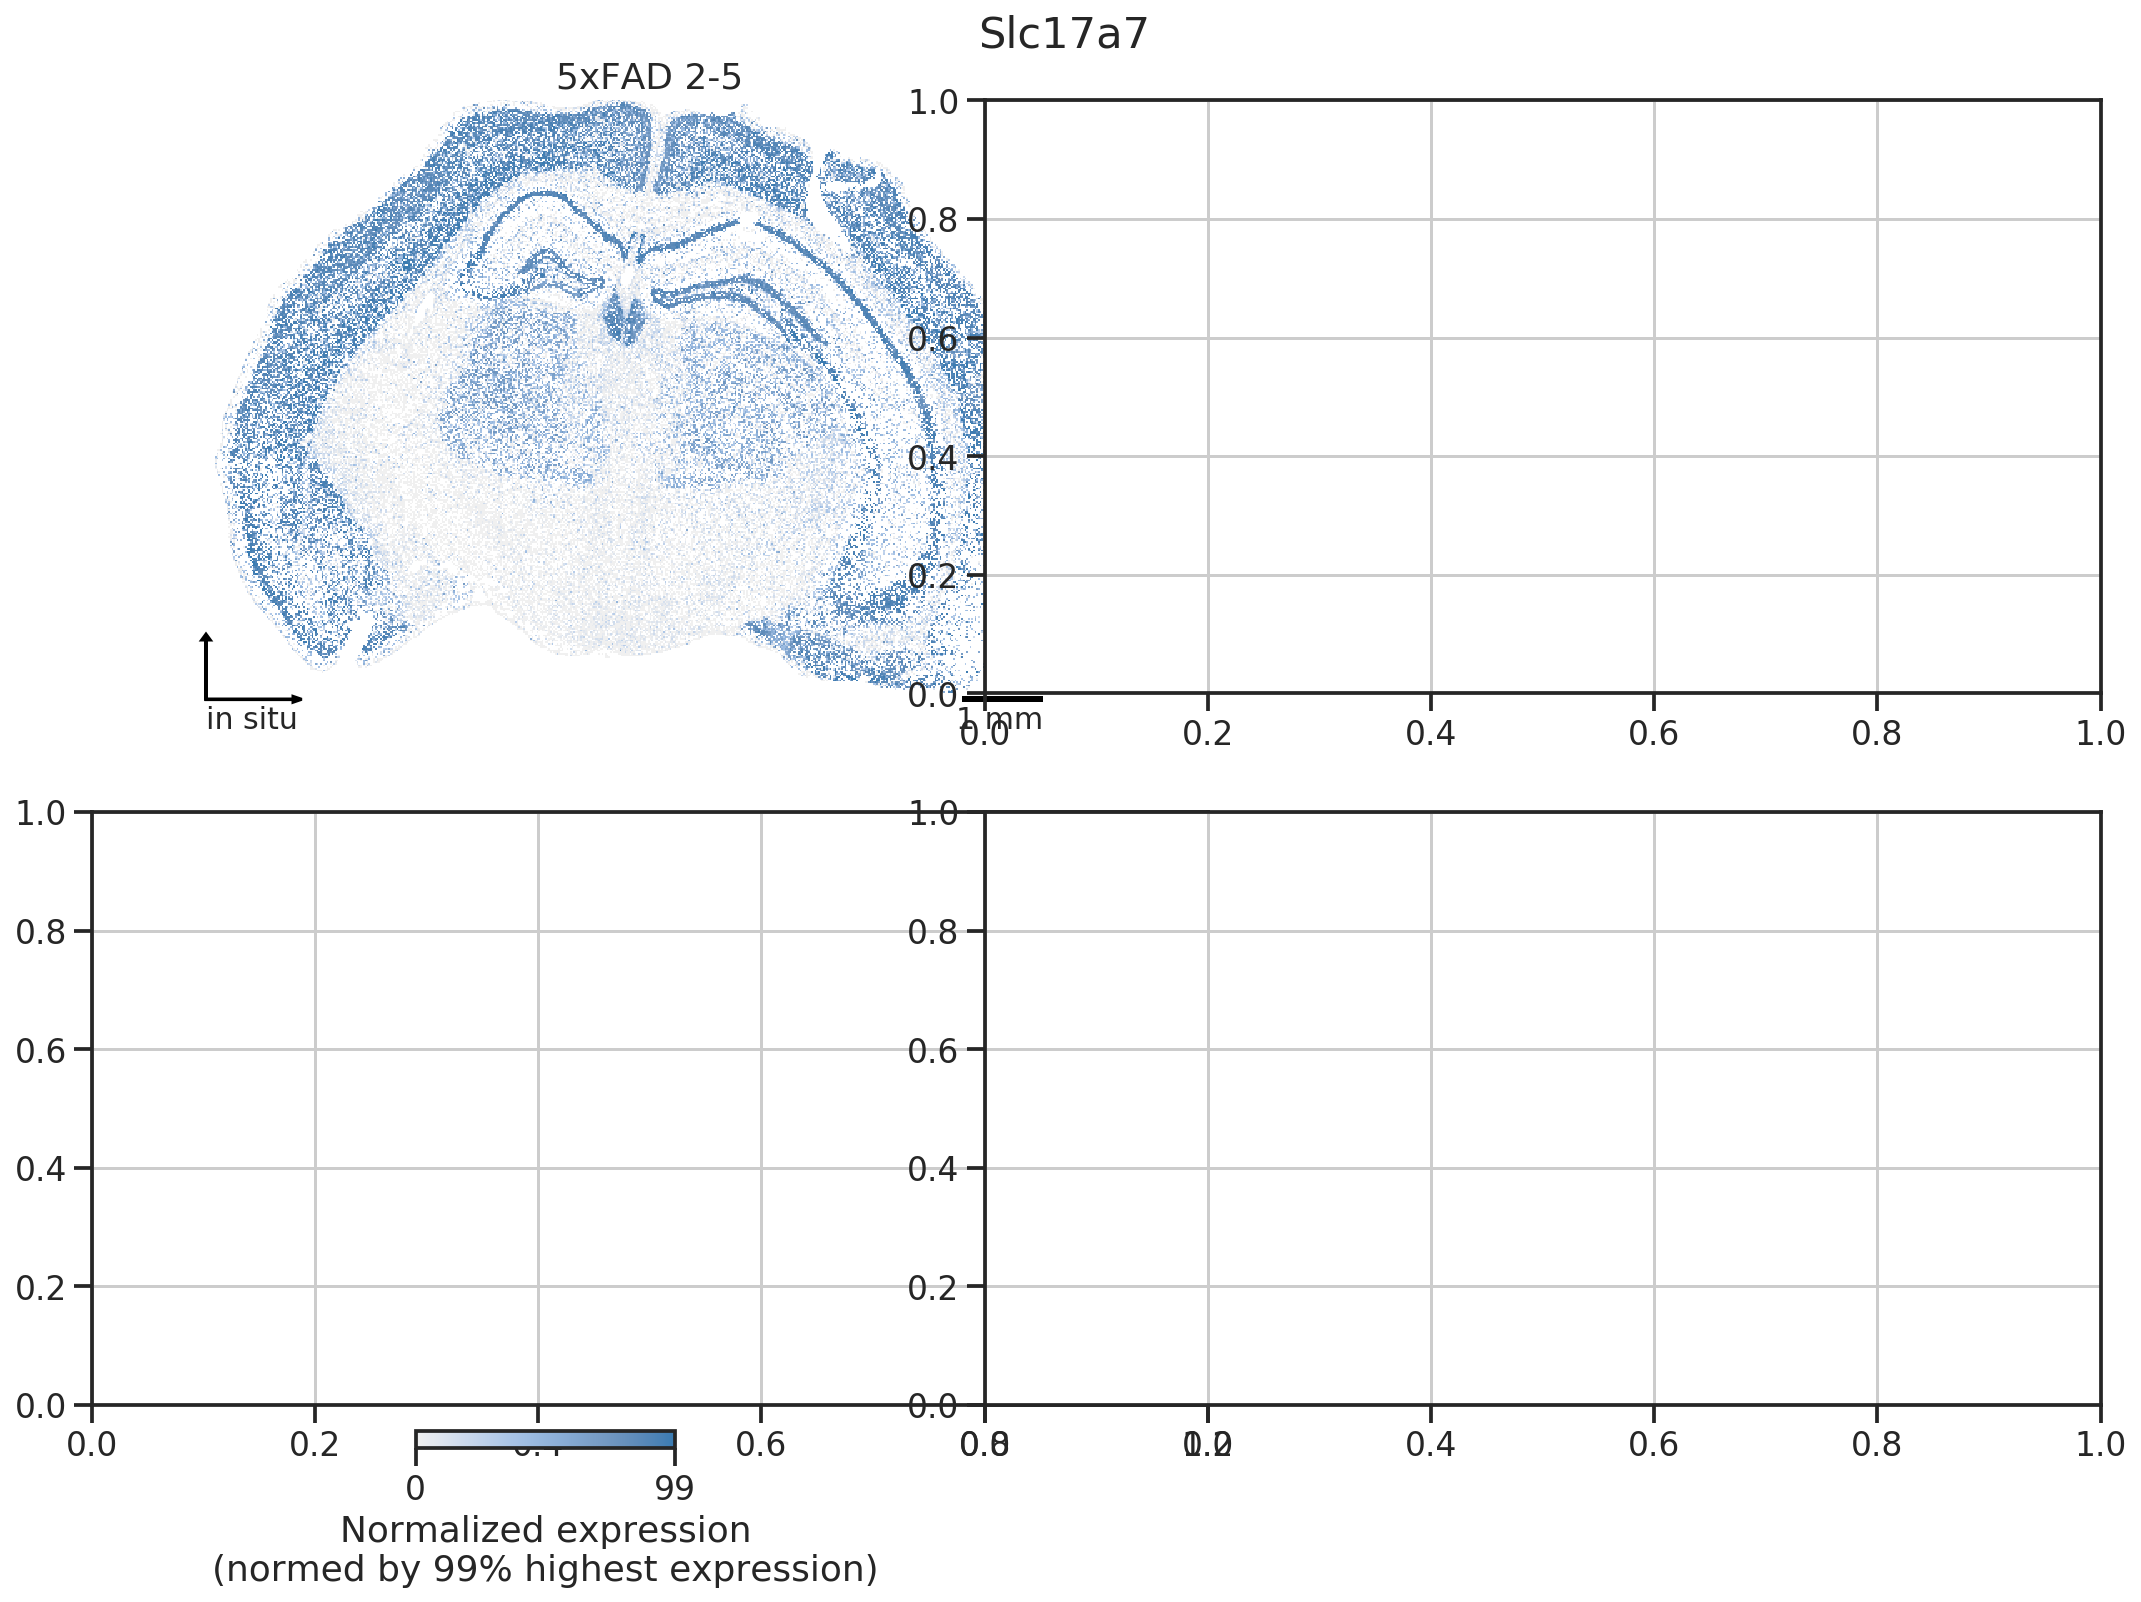

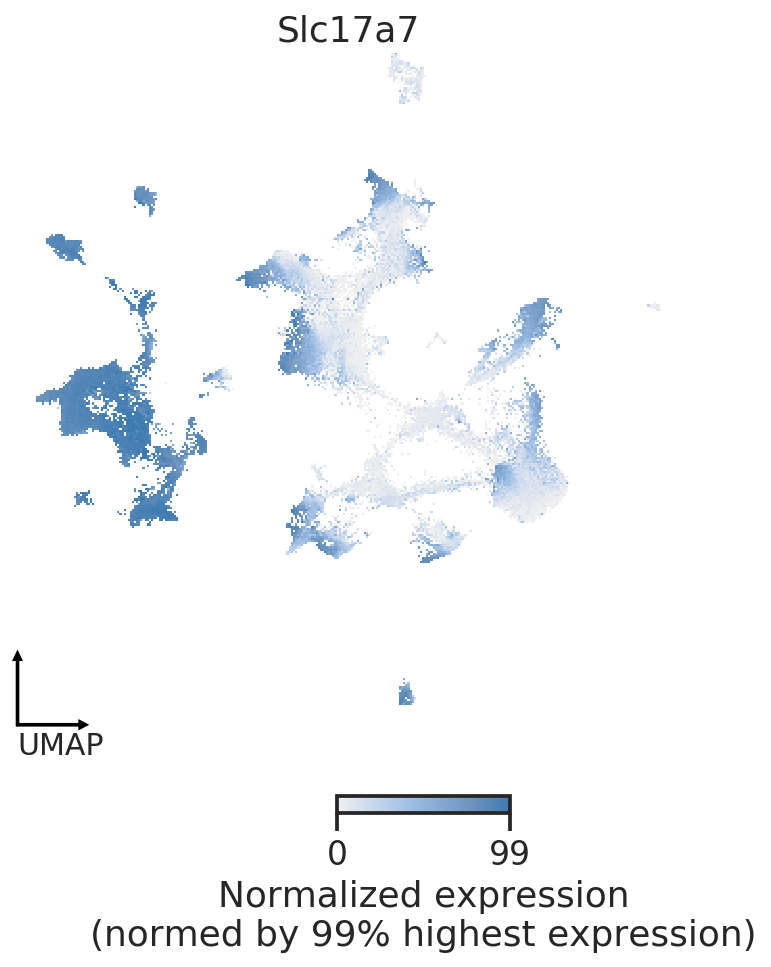

  0%|          | 0/1 [00:03<?, ?it/s]

../figures/2021-07-21_AD_mouse_umap_Slc17a7.pdf


In [15]:
# run genes view
selected_genes = ['Slc17a7']
for gene in tqdm.tqdm(selected_genes):
    # insitu 
    x, y, hue = 'x', 'y', gene
    output = figures.format("insitu_"+gene+".pdf")
    
    fig_plot_gene_insitu_routine(
        thedatagmat, samples, x, y, hue, 
        samples_annot=samples_annot,
        nx=2, ny=2, figsize=(9*2,6*2),
#         close=True,
#         output='', 
        output=output, 
        close=False,
        )
    print(output)
    
    # umap
    x, y, hue = 'umap_1', 'umap_2', gene
    output = figures.format("umap_"+gene+".pdf")
    
    fig_plot_gene_umap_routine(
        thedatagmat, x, y, hue, 
        output=output,
        close=False,
#         close=True,
        )
    print(output)
    break

### Run cluster viz (combined)

In [10]:
clusters = np.sort(thedata['cluster_cat'].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(clusters)
palette_clst = clstcolors_obj.to_dict(to_hex=True, output='../data/summary_tables_admouse/palette_clustering_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.json')

palette_clst

saved to file: ../data/summary_tables_admouse/palette_clustering_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.json


{'C1': '#0035f9',
 'C10': '#004bdf',
 'C11': '#005cc4',
 'C12': '#006da8',
 'C13': '#0e7891',
 'C14': '#2f8379',
 'C15': '#3b8c63',
 'C16': '#3f9648',
 'C17': '#3fa02b',
 'C18': '#4da910',
 'C19': '#65ae0e',
 'C2': '#7eb412',
 'C20': '#94b915',
 'C21': '#aabf19',
 'C22': '#bec31c',
 'C23': '#d3c820',
 'C24': '#e7cc23',
 'C25': '#f8cc24',
 'C26': '#fdc120',
 'C27': '#ffb41a',
 'C28': '#ffa714',
 'C3': '#ff990d',
 'C4': '#ff8b07',
 'C5': '#ff7b01',
 'C6': '#ff6c00',
 'C7': '#ff5900',
 'C8': '#ff4500',
 'C9': '#ff2a00'}

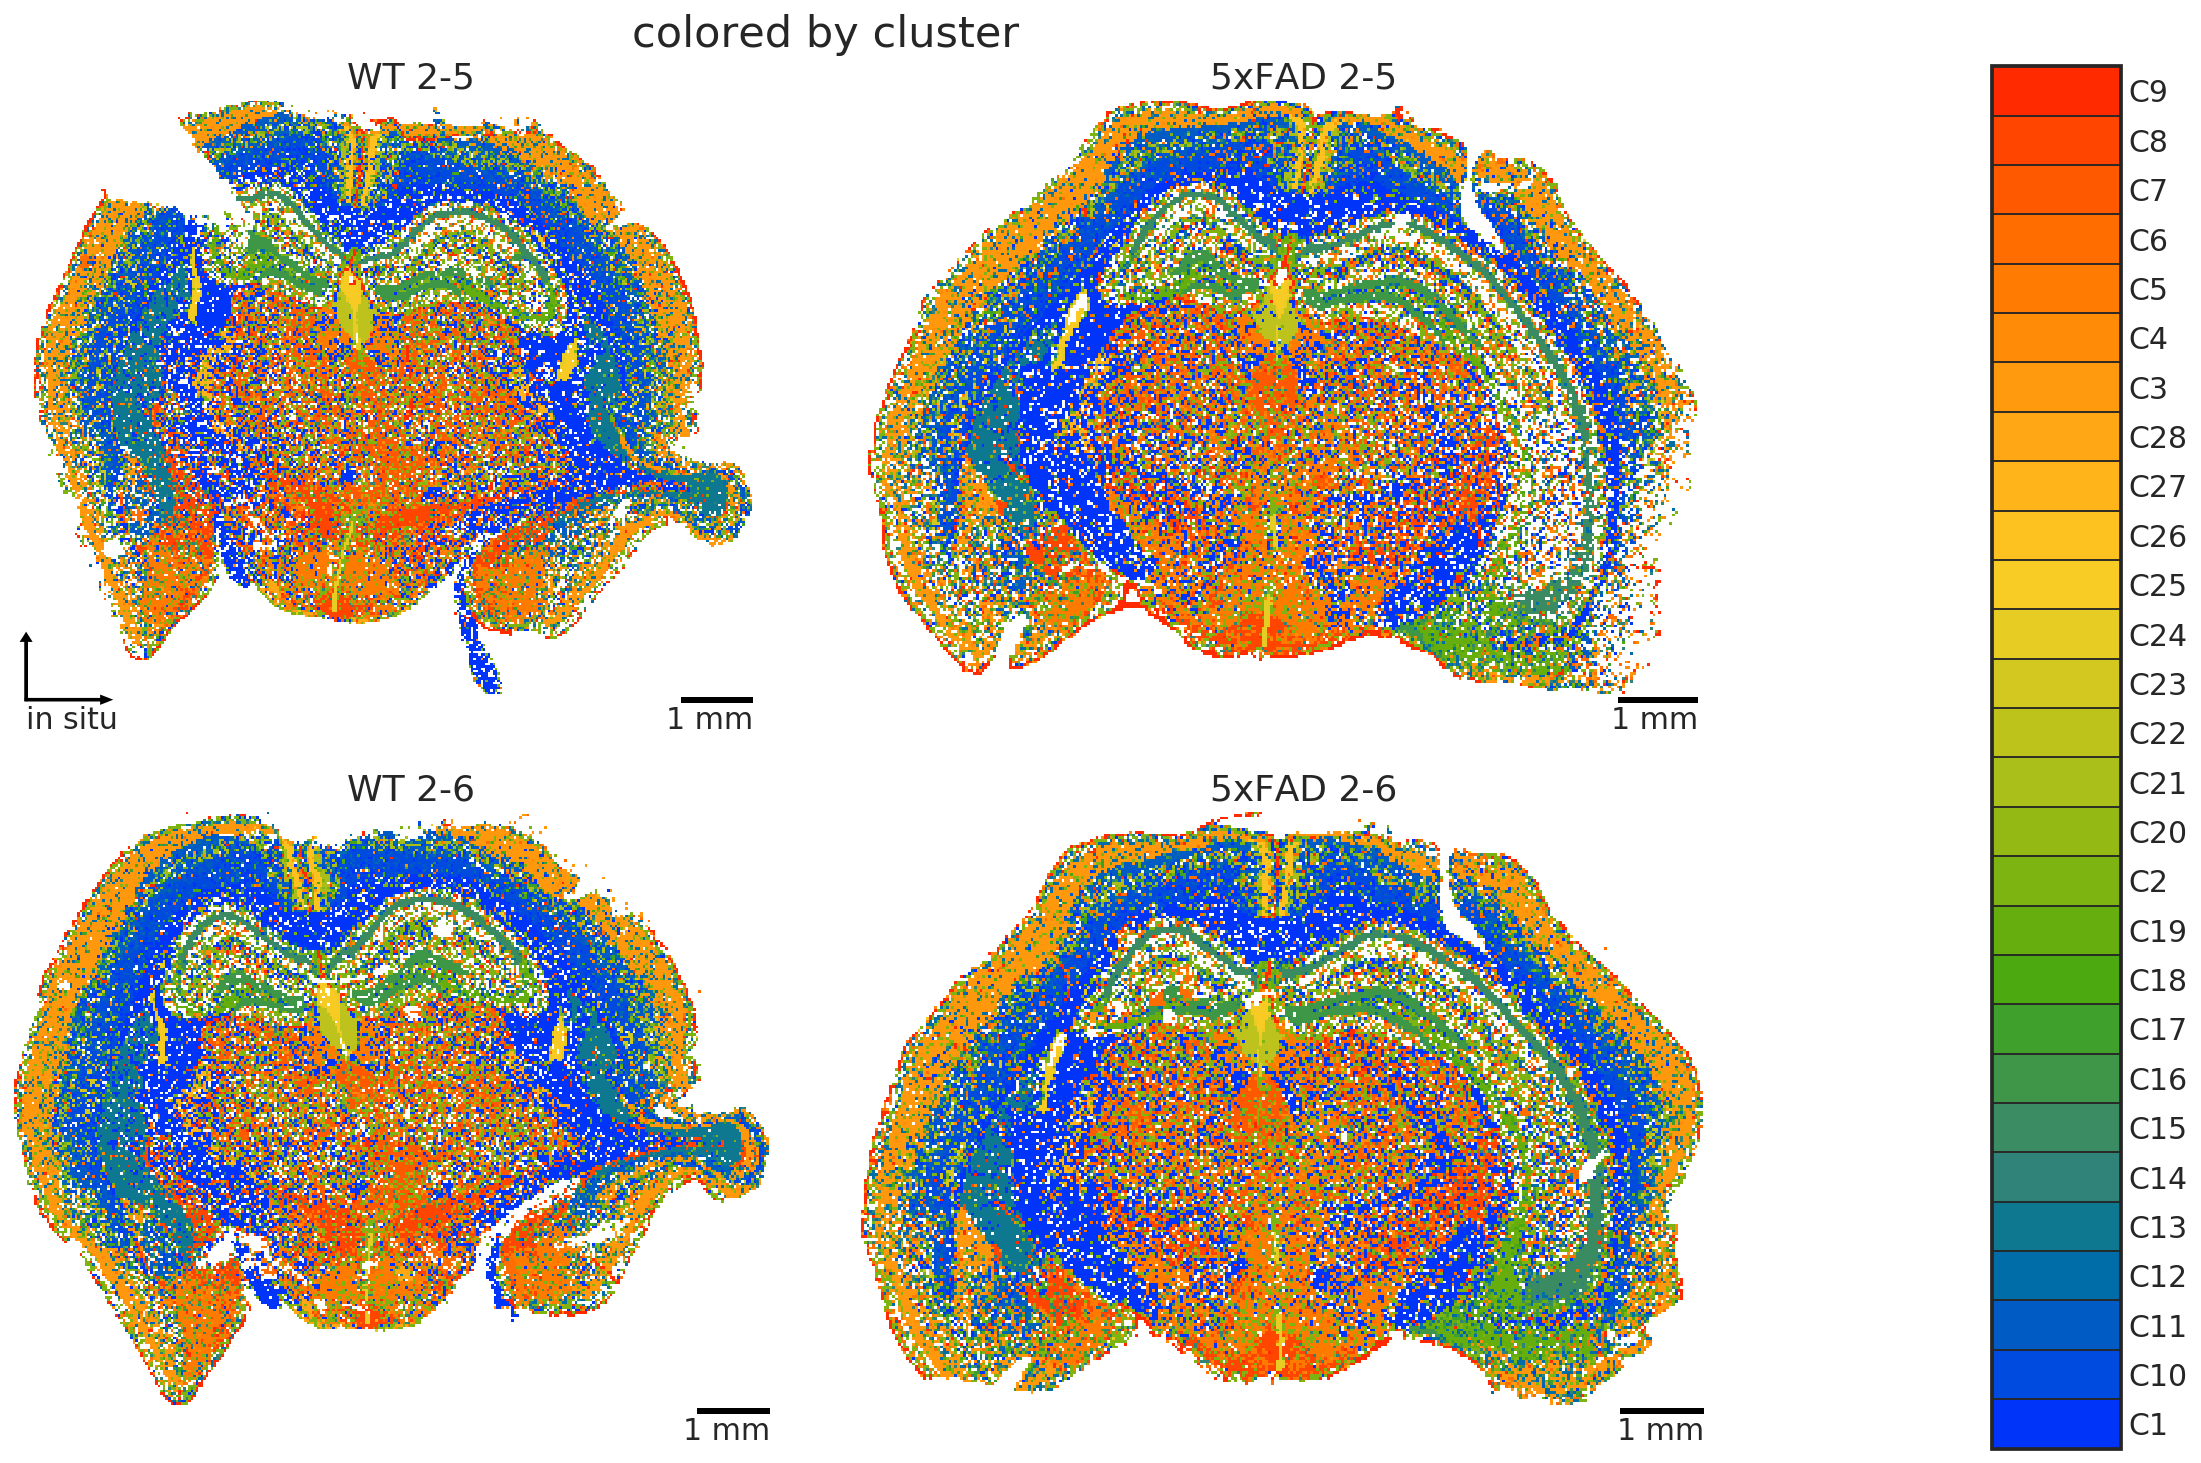

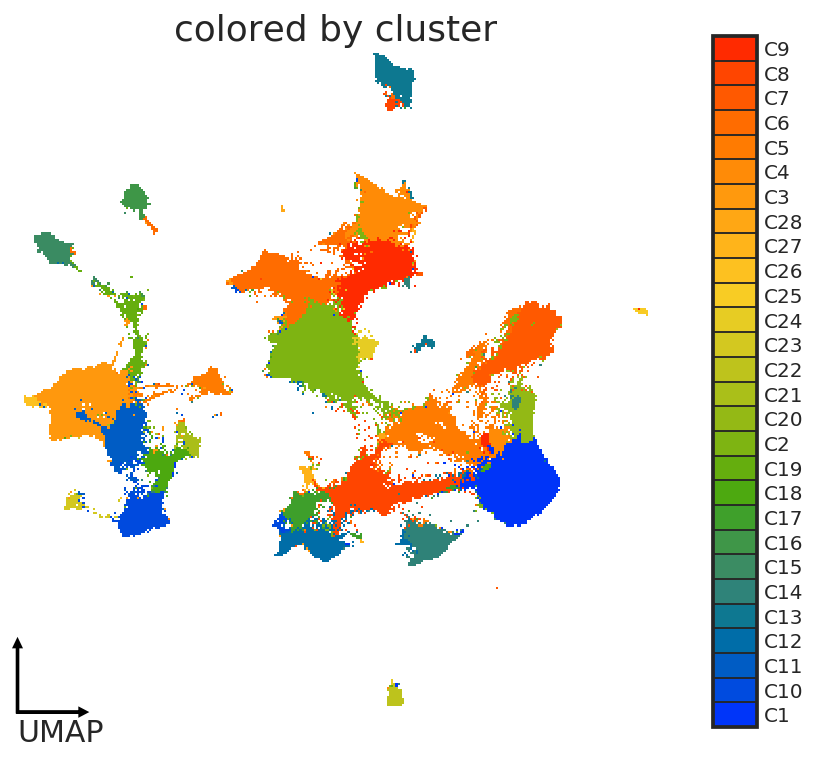

In [11]:
# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by cluster' 
output = figures.format("insitu_allclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    suptitle=suptitle,
    nx=2, ny=2, figsize=(9*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by cluster' 
output = figures.format("umap_allclsts"+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

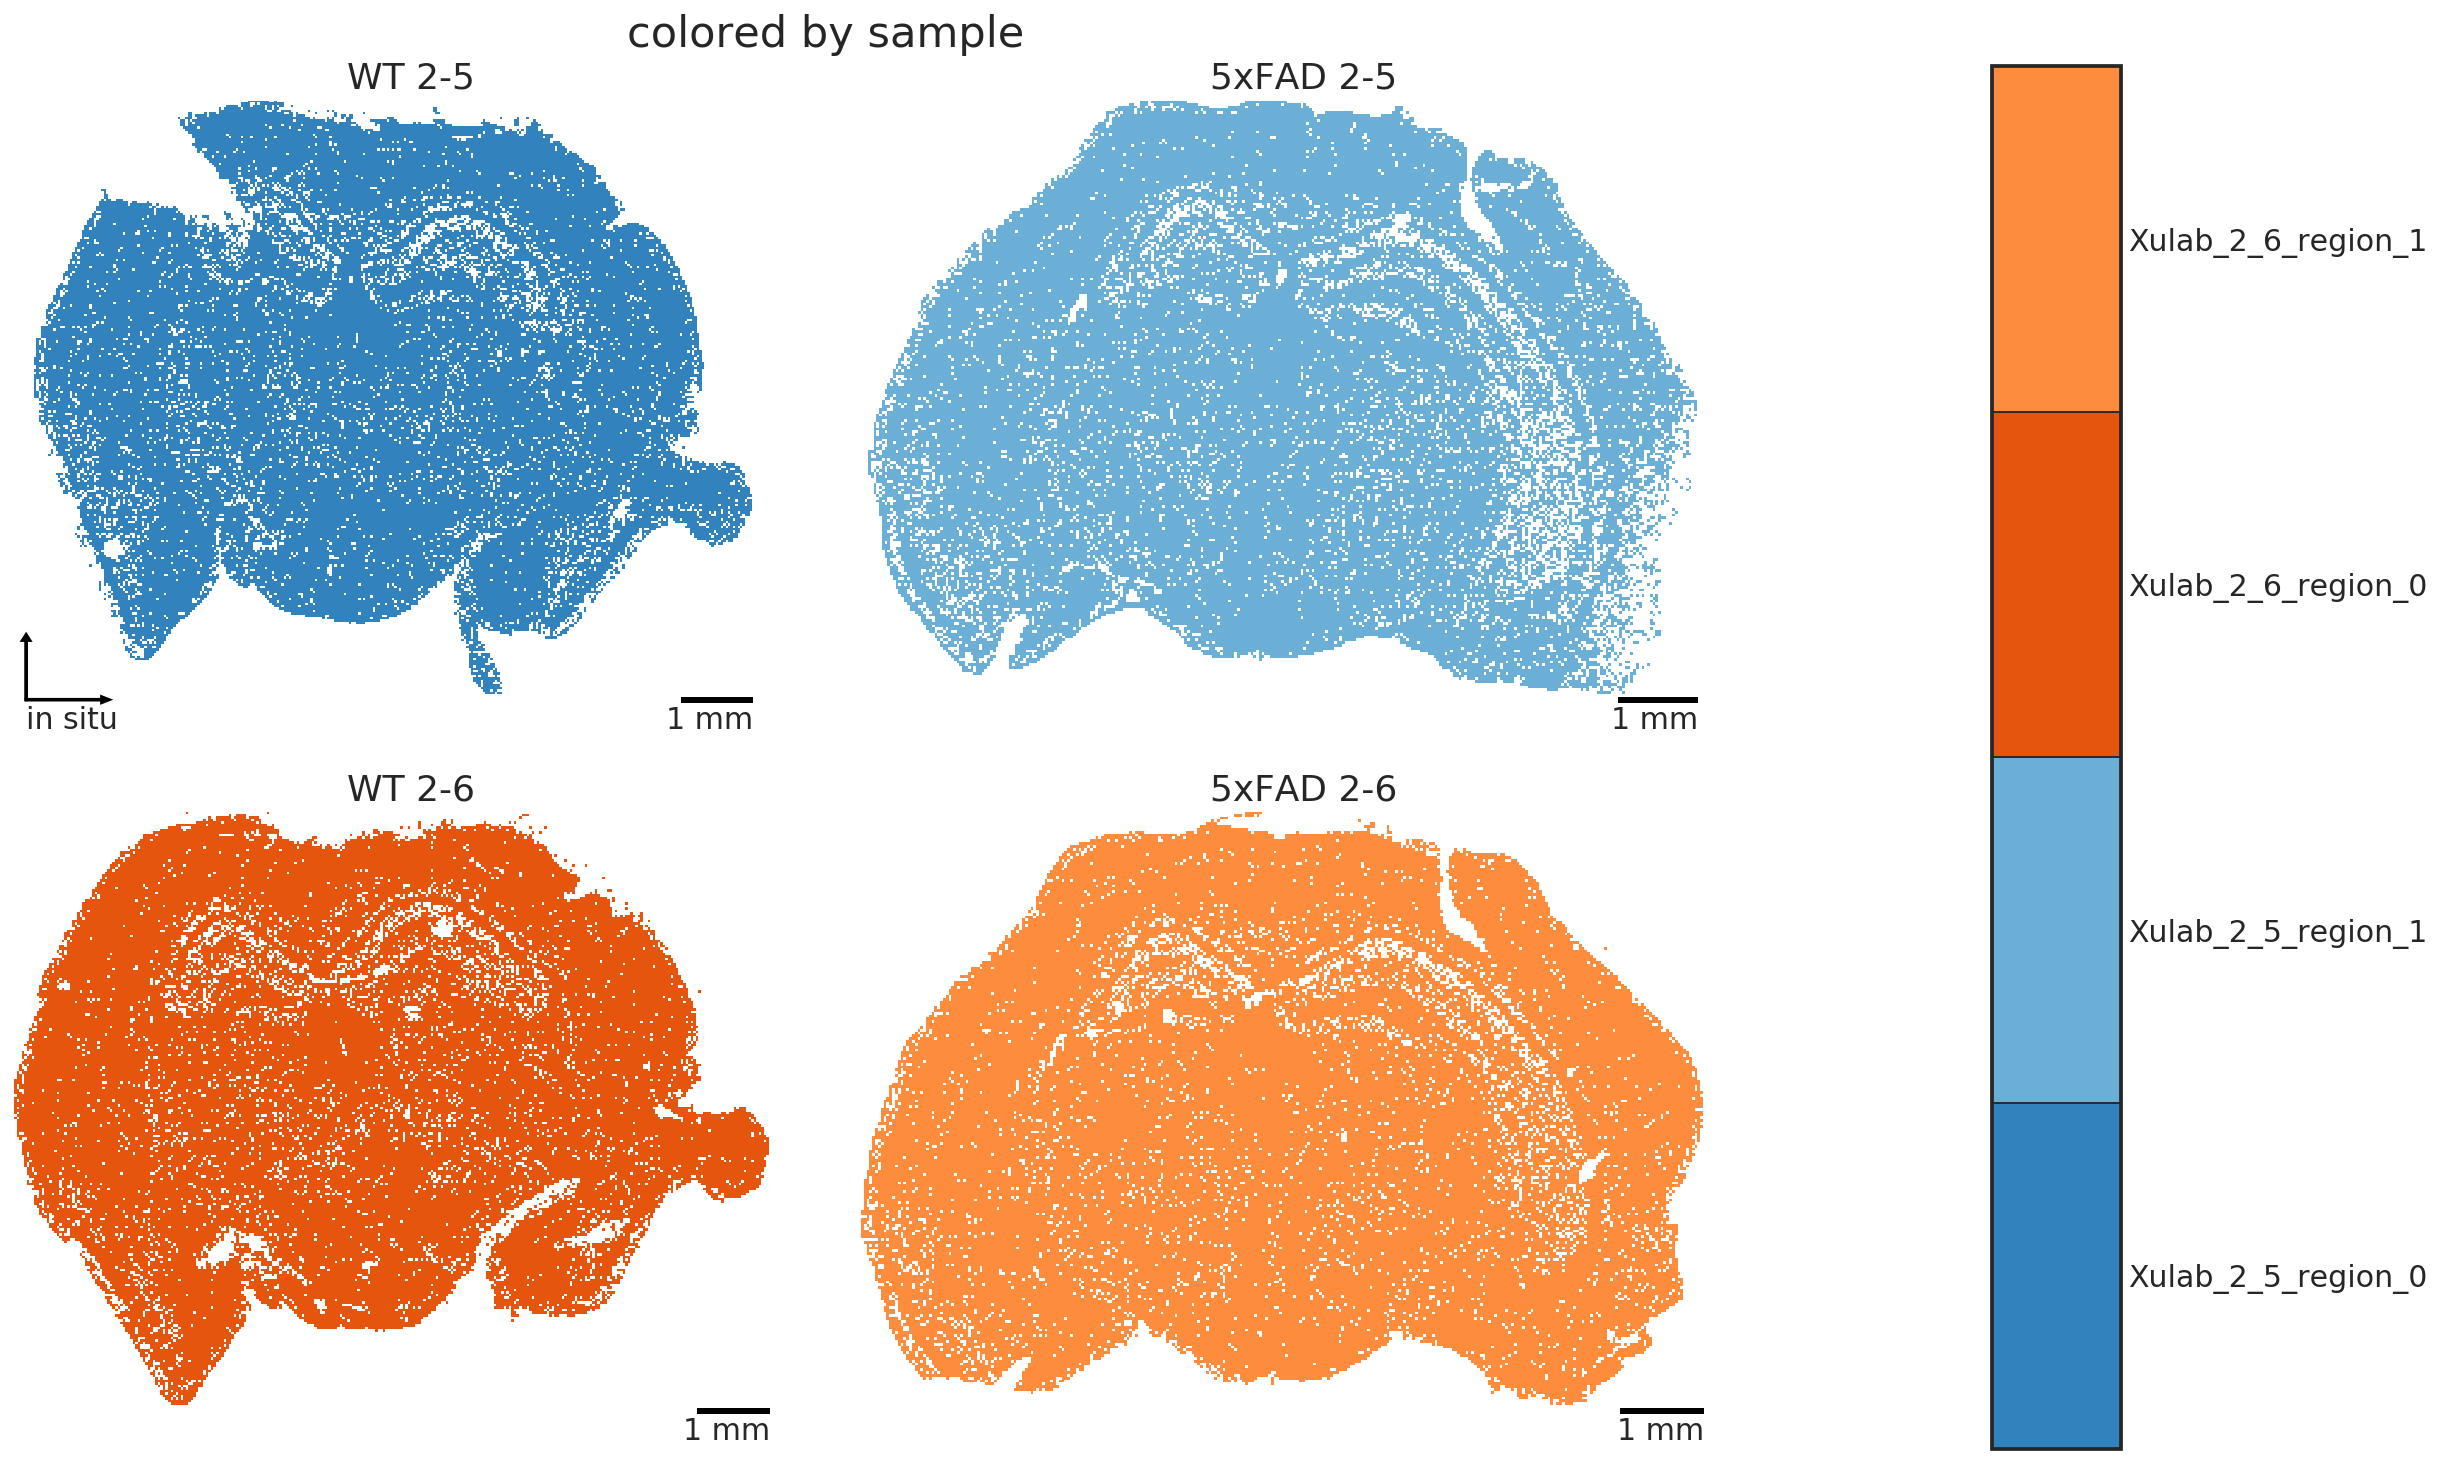

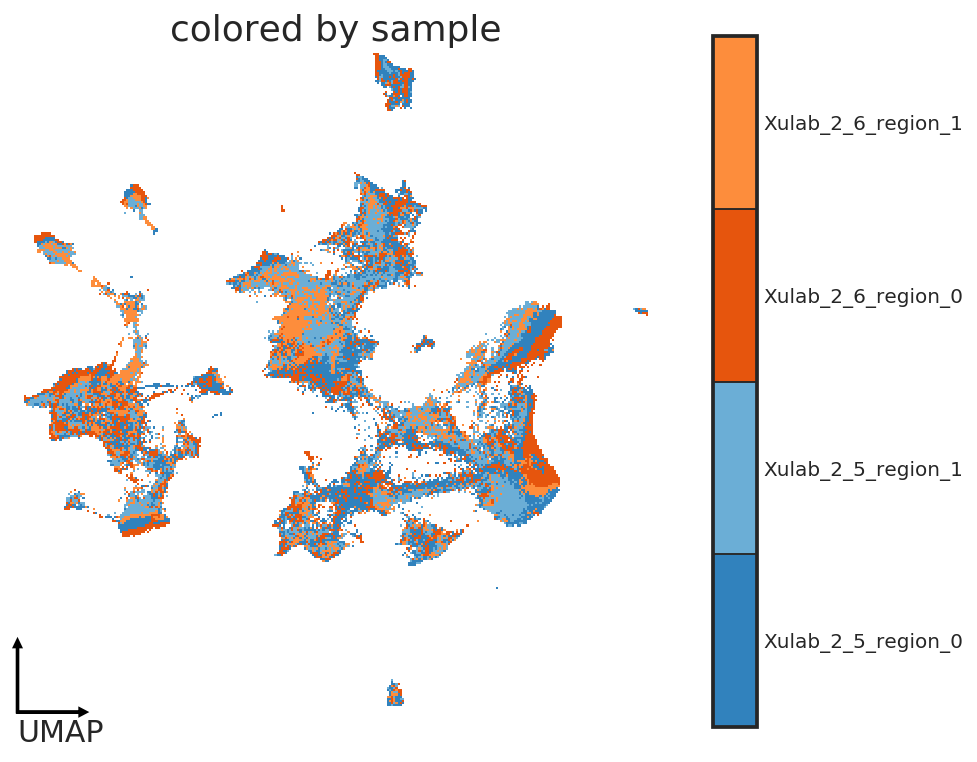

In [12]:
cat_col = 'sample_cat'
thedata[cat_col] = pd.Categorical(thedata['sample'])
categories = np.sort(thedata[cat_col].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(categories, [palette[catg] for catg in categories])

# agg data for each sample
x, y, hue = 'x', 'y', cat_col
suptitle = 'colored by sample' 
output = figures.format("insitu_allclsts_"+cat_col+".pdf")
close = False
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    suptitle=suptitle,
    nx=2, ny=2, figsize=(9*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', cat_col
title = 'colored by sample'
output = figures.format("umap_allclsts_"+cat_col+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

In [13]:
# # selected clusters (preserve colors)
# clstcolors_obj = powerplot.CategoricalColors(
#     clusters)
# colors = clstcolors_obj.colors

# selected_clusters = ['C15', 'C16', 'C19']
# selected_colors = [
#     color if label in selected_clusters else 'lightgray'
#     for color, label in zip(colors, clusters)
# ]
# selected_clstcolors_obj = powerplot.CategoricalColors(
#     clusters, selected_colors,
# )

# selected clusters (not preserve colors)
colors = ['lightgray']*len(clusters)
selected_clusters = ['C15', 'C16', 'C19']
selected_colors = powerplot.CategoricalColors(selected_clusters).colors
for i, clst in enumerate(selected_clusters):
    idx = np.where(clusters==clst)[0][0]
    colors[idx] = selected_colors[i]
selected_clstcolors_obj = powerplot.CategoricalColors(clusters, colors)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


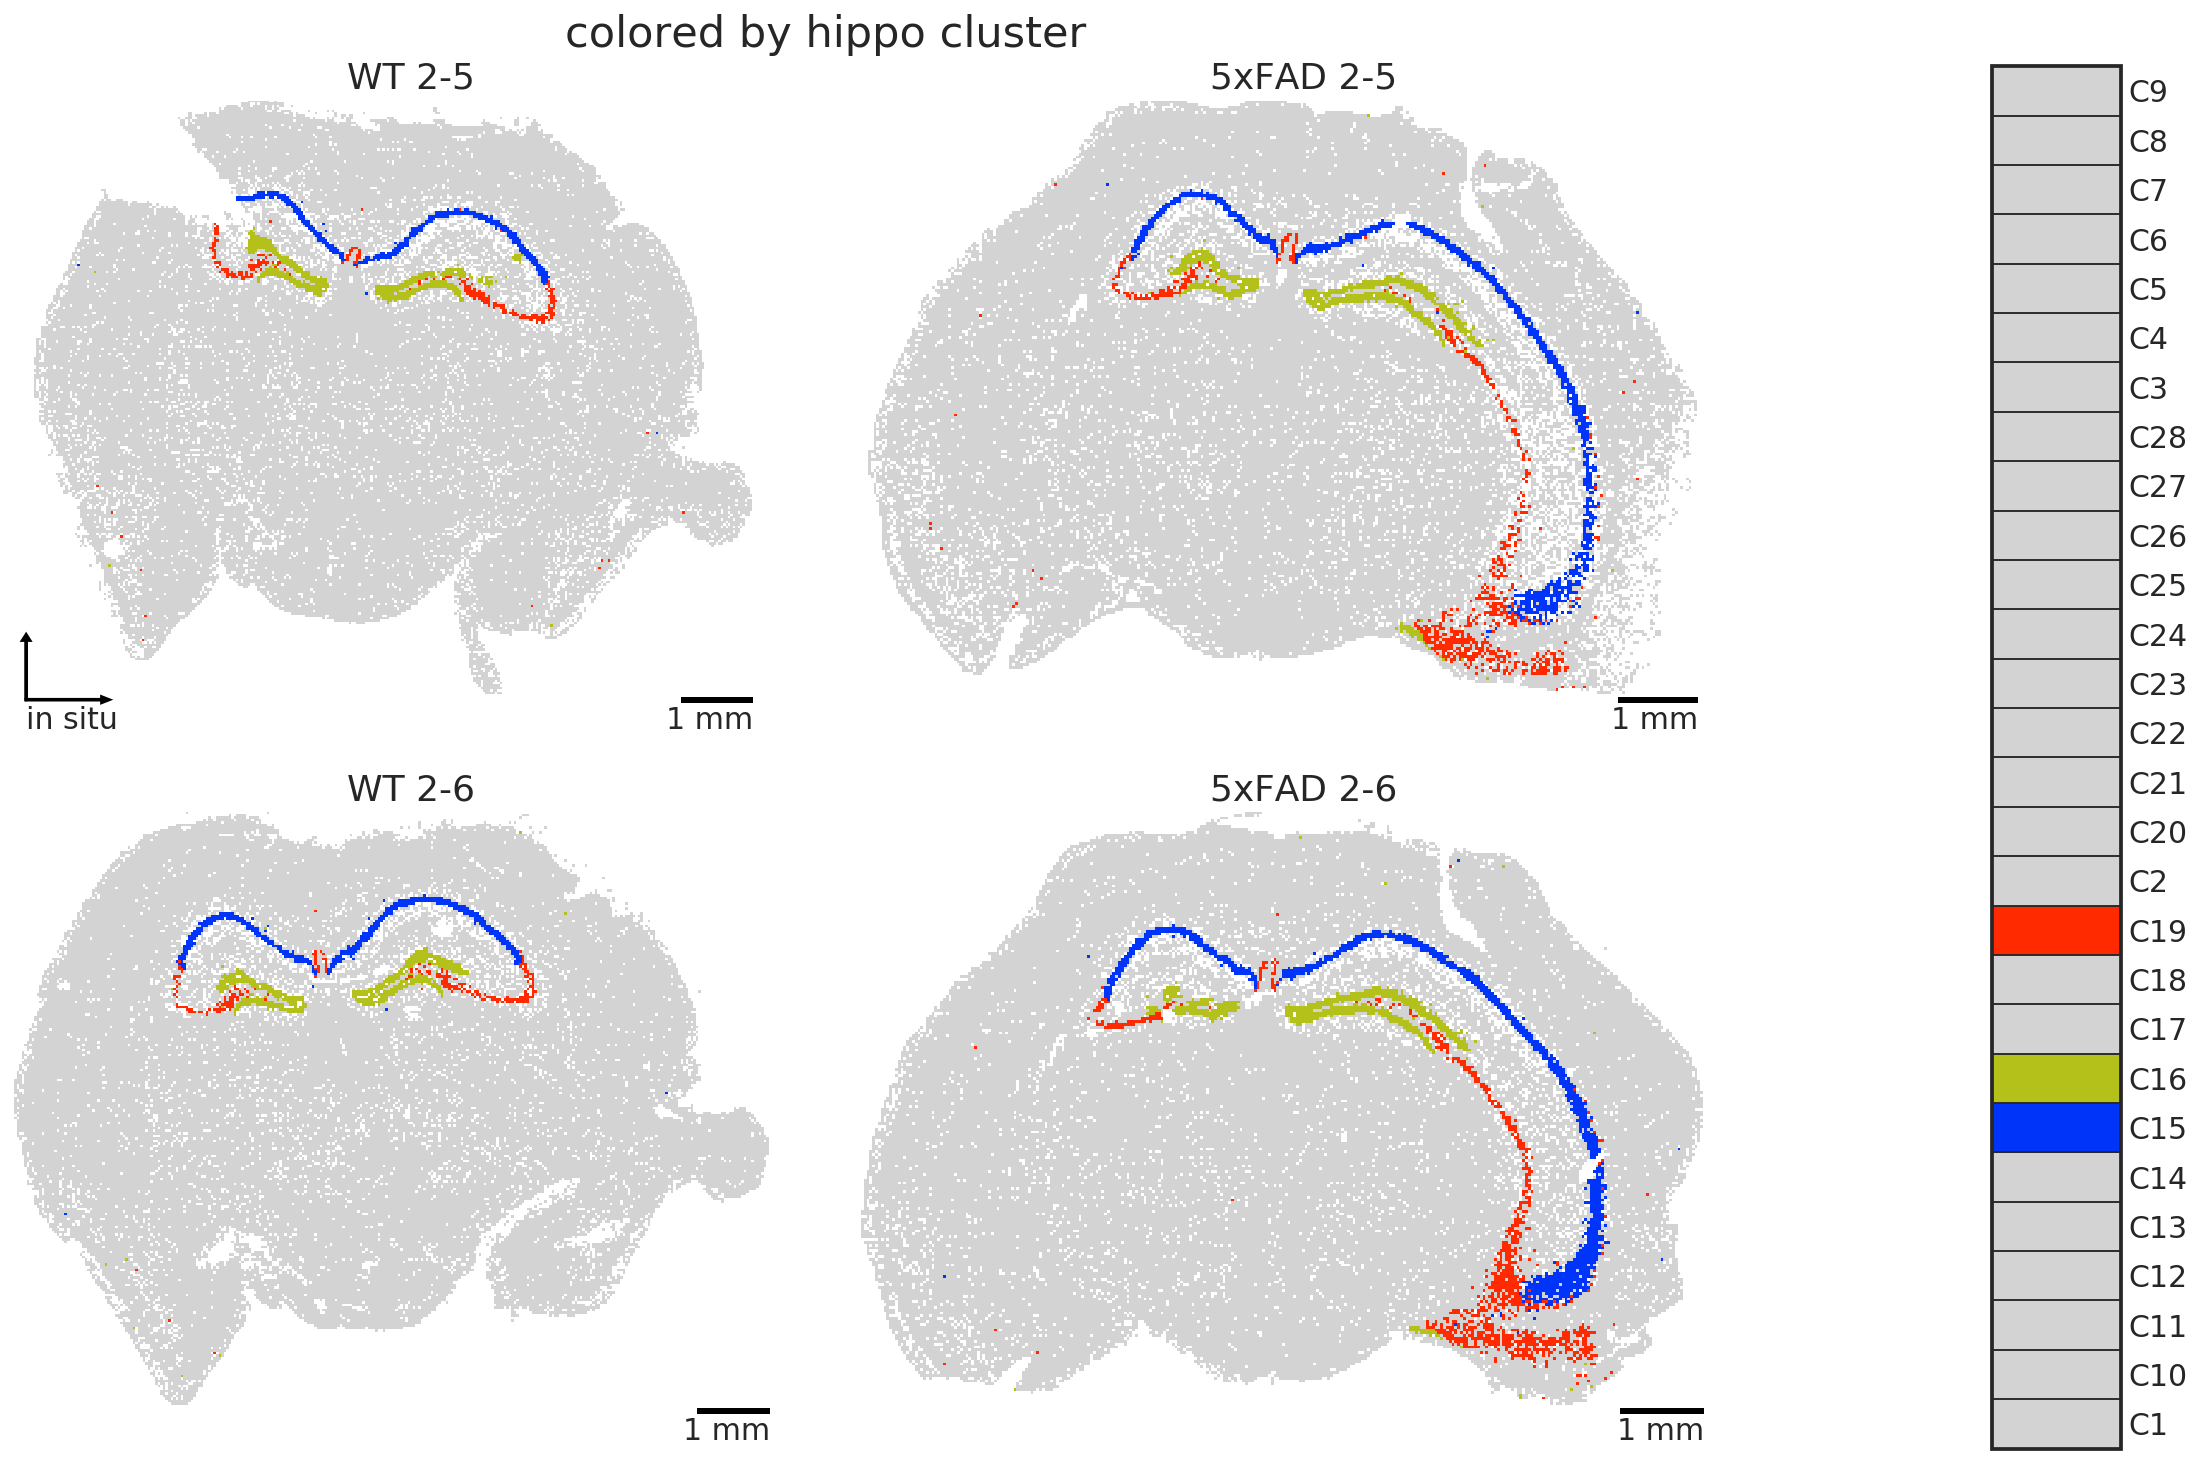

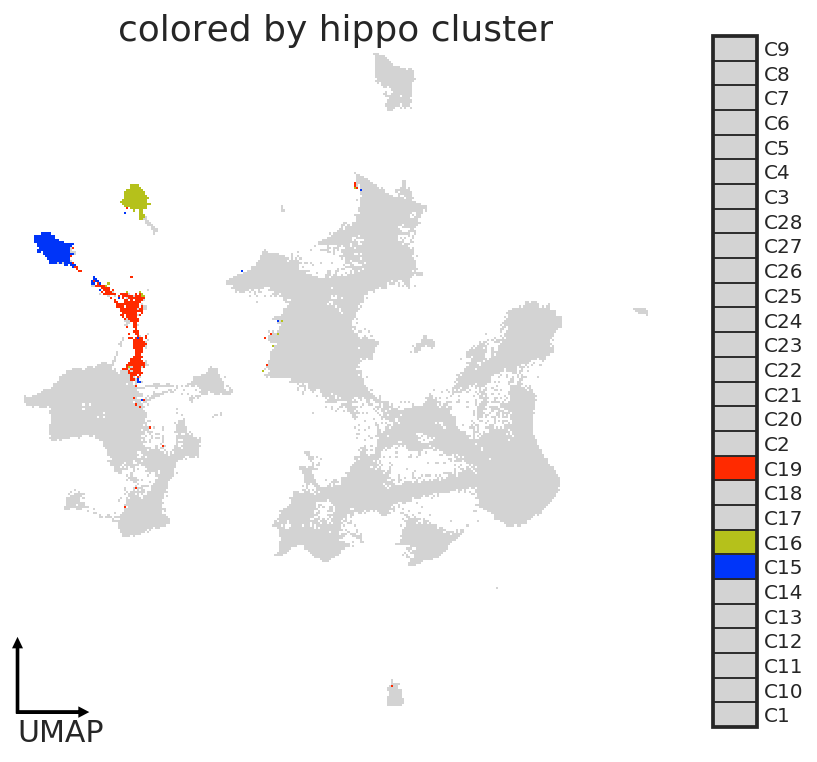

In [14]:

# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by hippo cluster' 
output = figures.format("insitu_hippoclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    selected_clstcolors_obj,
    suptitle=suptitle,
    samples_annot=samples_annot,
    nx=2, ny=2, figsize=(9*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by hippo cluster' 
output = figures.format("umap_hippoclsts"+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    selected_clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

# barplots -- number of cells for each clusters

## all gene analyses
- WT vs 5xFAD (2), cell types (N), replicates (2)
- get an heatmap - Ngenes * 4Ncelltypes 

In [15]:
# select hemi-brain sections
filter_cond = (
    ((thedatagmat['sample'] == 'Xulab_2_5_region_0') & (thedatagmat['x'] > 0))
    | ((thedatagmat['sample'] == 'Xulab_2_5_region_1') & (thedatagmat['x'] < 0))
    | ((thedatagmat['sample'] == 'Xulab_2_6_region_0') & (thedatagmat['x'] < 0))
    | ((thedatagmat['sample'] == 'Xulab_2_6_region_1') & (thedatagmat['x'] < 0))
)

# selecteddata
thedatagmat['sample_name'] = thedatagmat['sample'].apply(lambda x: samples_annot[x])
selecteddata = thedatagmat[filter_cond]

# mean, std, n, zscore 
gmat_mean = selecteddata.groupby(['cluster', 'sample_name']).mean()[genes]
gmat_std = selecteddata.groupby(['cluster', 'sample_name']).std()[genes]
gmat_n = selecteddata.groupby(['cluster', 'sample_name']).count()[genes]
gmat_meanz = (gmat_mean - gmat_mean.mean())/gmat_mean.std()

# celltypes
celltypes = gmat_mean.index.levels[0].values

print(thedatagmat.shape, selecteddata.shape)
print(gmat_mean.shape, gmat_std.shape, gmat_n.shape, gmat_meanz.shape)

(450001, 168) (226345, 168)
(112, 150) (112, 150) (112, 150) (112, 150)


In [16]:
# mean diff and statistical significant diff

rescale = np.log(10)/np.log(2)

ctrl, case = 'WT 2-5', '5xFAD 2-5'

query_ctrl = 'sample_name == "{}"'.format(ctrl)
query_case = 'sample_name == "{}"'.format(case)
diff1 = (gmat_mean.query(query_case).droplevel(level=1)
         - gmat_mean.query(query_ctrl).droplevel(level=1)
        ).loc[celltypes]*rescale
diff1['slice'] = "2-5"
diff1 = diff1.set_index('slice', append=True)

ctrl, case = 'WT 2-6', '5xFAD 2-6'

query_ctrl = 'sample_name == "{}"'.format(ctrl)
query_case = 'sample_name == "{}"'.format(case)
diff2 = (gmat_mean.query(query_case).droplevel(level=1)
         - gmat_mean.query(query_ctrl).droplevel(level=1)
        ).loc[celltypes]*rescale
diff2['slice'] = "2-6"
diff2 = diff2.set_index('slice', append=True)

diffmat = pd.concat([diff1, diff2]).sort_index(level=0)
print(diffmat.shape)

# sig diff
alpha = 0.05

ctrl, case = 'WT 2-5', '5xFAD 2-5'

query_ctrl = 'sample_name == "{}"'.format(ctrl)
query_case = 'sample_name == "{}"'.format(case)
t, p = stats.ttest_ind_from_stats(
    gmat_mean.query(query_ctrl).loc[celltypes].values,
    gmat_std.query(query_ctrl).loc[celltypes].values,
    gmat_n.query(query_ctrl).loc[celltypes].values,
    gmat_mean.query(query_case).loc[celltypes].values,
    gmat_std.query(query_case).loc[celltypes].values,
    gmat_n.query(query_case).loc[celltypes].values,
)
p[np.isnan(p)] = 1
q = utils.get_fdr(p.reshape(-1)).reshape(p.shape)
q = pd.DataFrame(q, index=celltypes, columns=genes)
q['slice'] = "2-5"
q = q.set_index('slice', append=True)
rej = q<alpha

q1 = q
rej1 = rej

ctrl, case = 'WT 2-6', '5xFAD 2-6'

query_ctrl = 'sample_name == "{}"'.format(ctrl)
query_case = 'sample_name == "{}"'.format(case)
t, p = stats.ttest_ind_from_stats(
    gmat_mean.query(query_ctrl).loc[celltypes].values,
    gmat_std.query(query_ctrl).loc[celltypes].values,
    gmat_n.query(query_ctrl).loc[celltypes].values,
    gmat_mean.query(query_case).loc[celltypes].values,
    gmat_std.query(query_case).loc[celltypes].values,
    gmat_n.query(query_case).loc[celltypes].values,
)
p[np.isnan(p)] = 1
q = utils.get_fdr(p.reshape(-1)).reshape(p.shape)
q = pd.DataFrame(q, index=celltypes, columns=genes)
q['slice'] = "2-6"
q = q.set_index('slice', append=True)
rej = q<alpha

q2 = q
rej2 = rej

qmat = pd.concat([q1, q2]).sort_index(level=0)
rejmat = pd.concat([rej1, rej2]).sort_index(level=0)
# rejmat

(56, 150)


../figures/2021-07-02_AD_mouse_gene_by_clusters_separate_samples.pdf


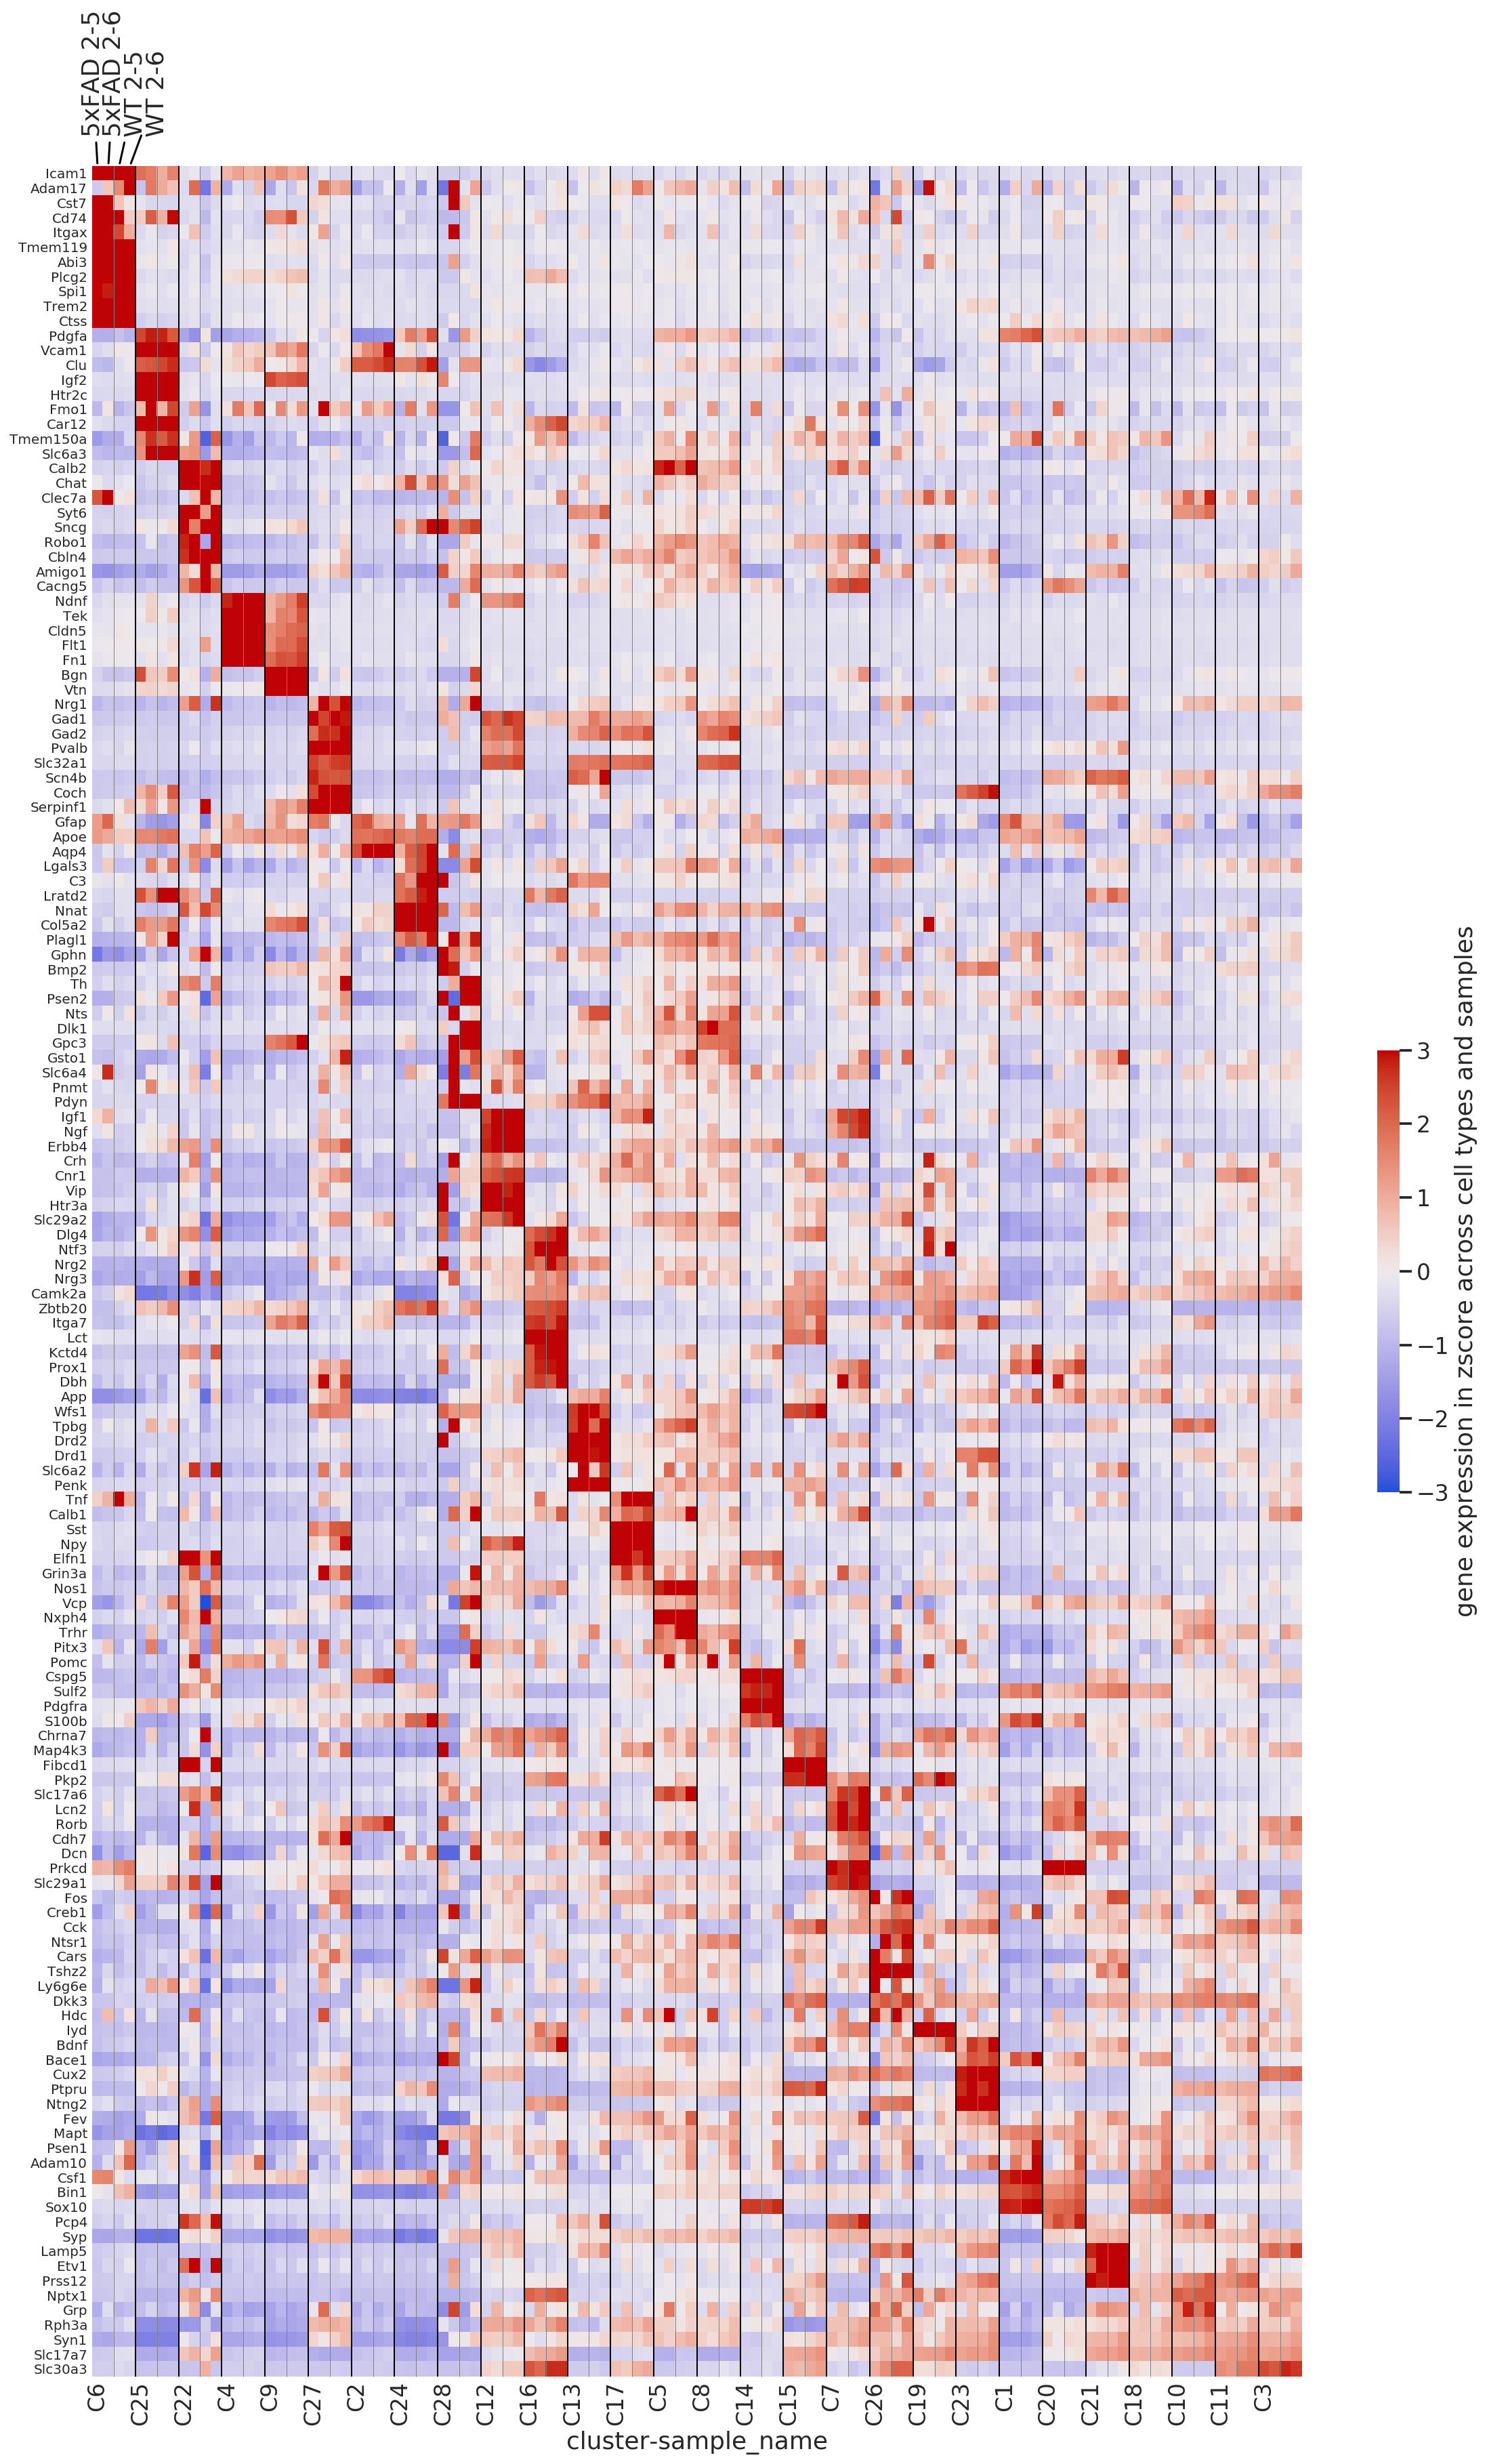

In [18]:
output = figures.format("gene_by_clusters_separate_samples.pdf")

heatmat = gmat_meanz.T

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([4*col+np.array([0,1,2,3]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([4*col+np.array([0,1,2,3]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)

fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell types and samples'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(4): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.vlines(np.arange(0, ncol, 4)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)
ax.vlines(np.arange(2, ncol, 4), 0, nrow, color='gray', linewidth=0.5, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

cluster_orders = col_order_reduced

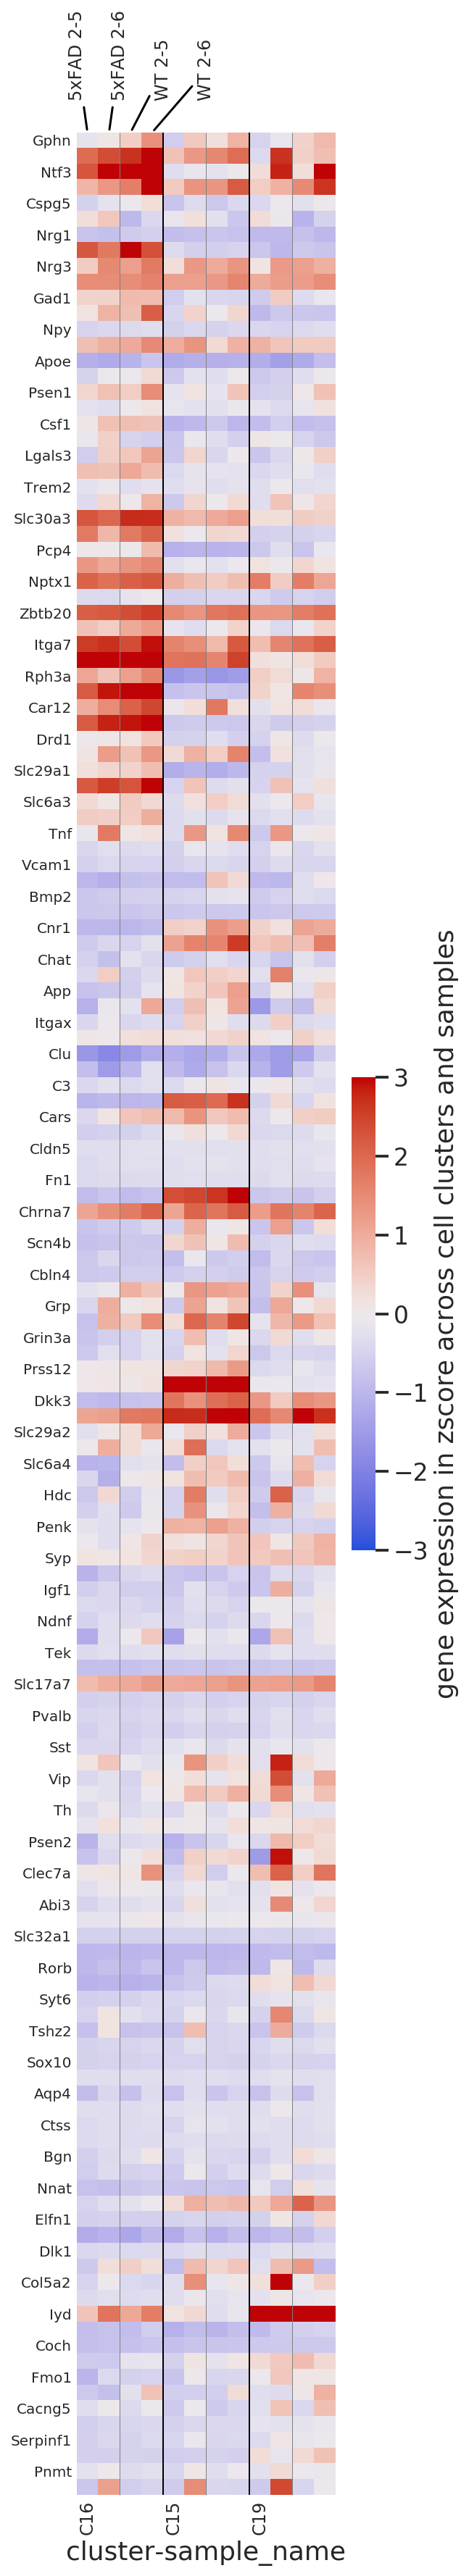

In [19]:
heatmat = gmat_meanz.loc[selected_clusters].T

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([4*col+np.array([0,1,2,3]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([4*col+np.array([0,1,2,3]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)

fig, ax = plt.subplots(figsize=(4, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order],
#     heatmat.iloc[rowidx, colidx],
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    cmap=colorcet.coolwarm,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell clusters and samples'),
    ax=ax,
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp, fontsize=12)
for i in range(4): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
                fontsize=12,
               )


ax.vlines(np.arange(0, ncol, 4)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)
ax.vlines(np.arange(2, ncol, 4), 0, nrow, color='gray', linewidth=0.5, clip_on=False)
plt.show()

../figures/2021-07-02_AD_mouse_gene_diff_5xFAD_vs_WT.pdf


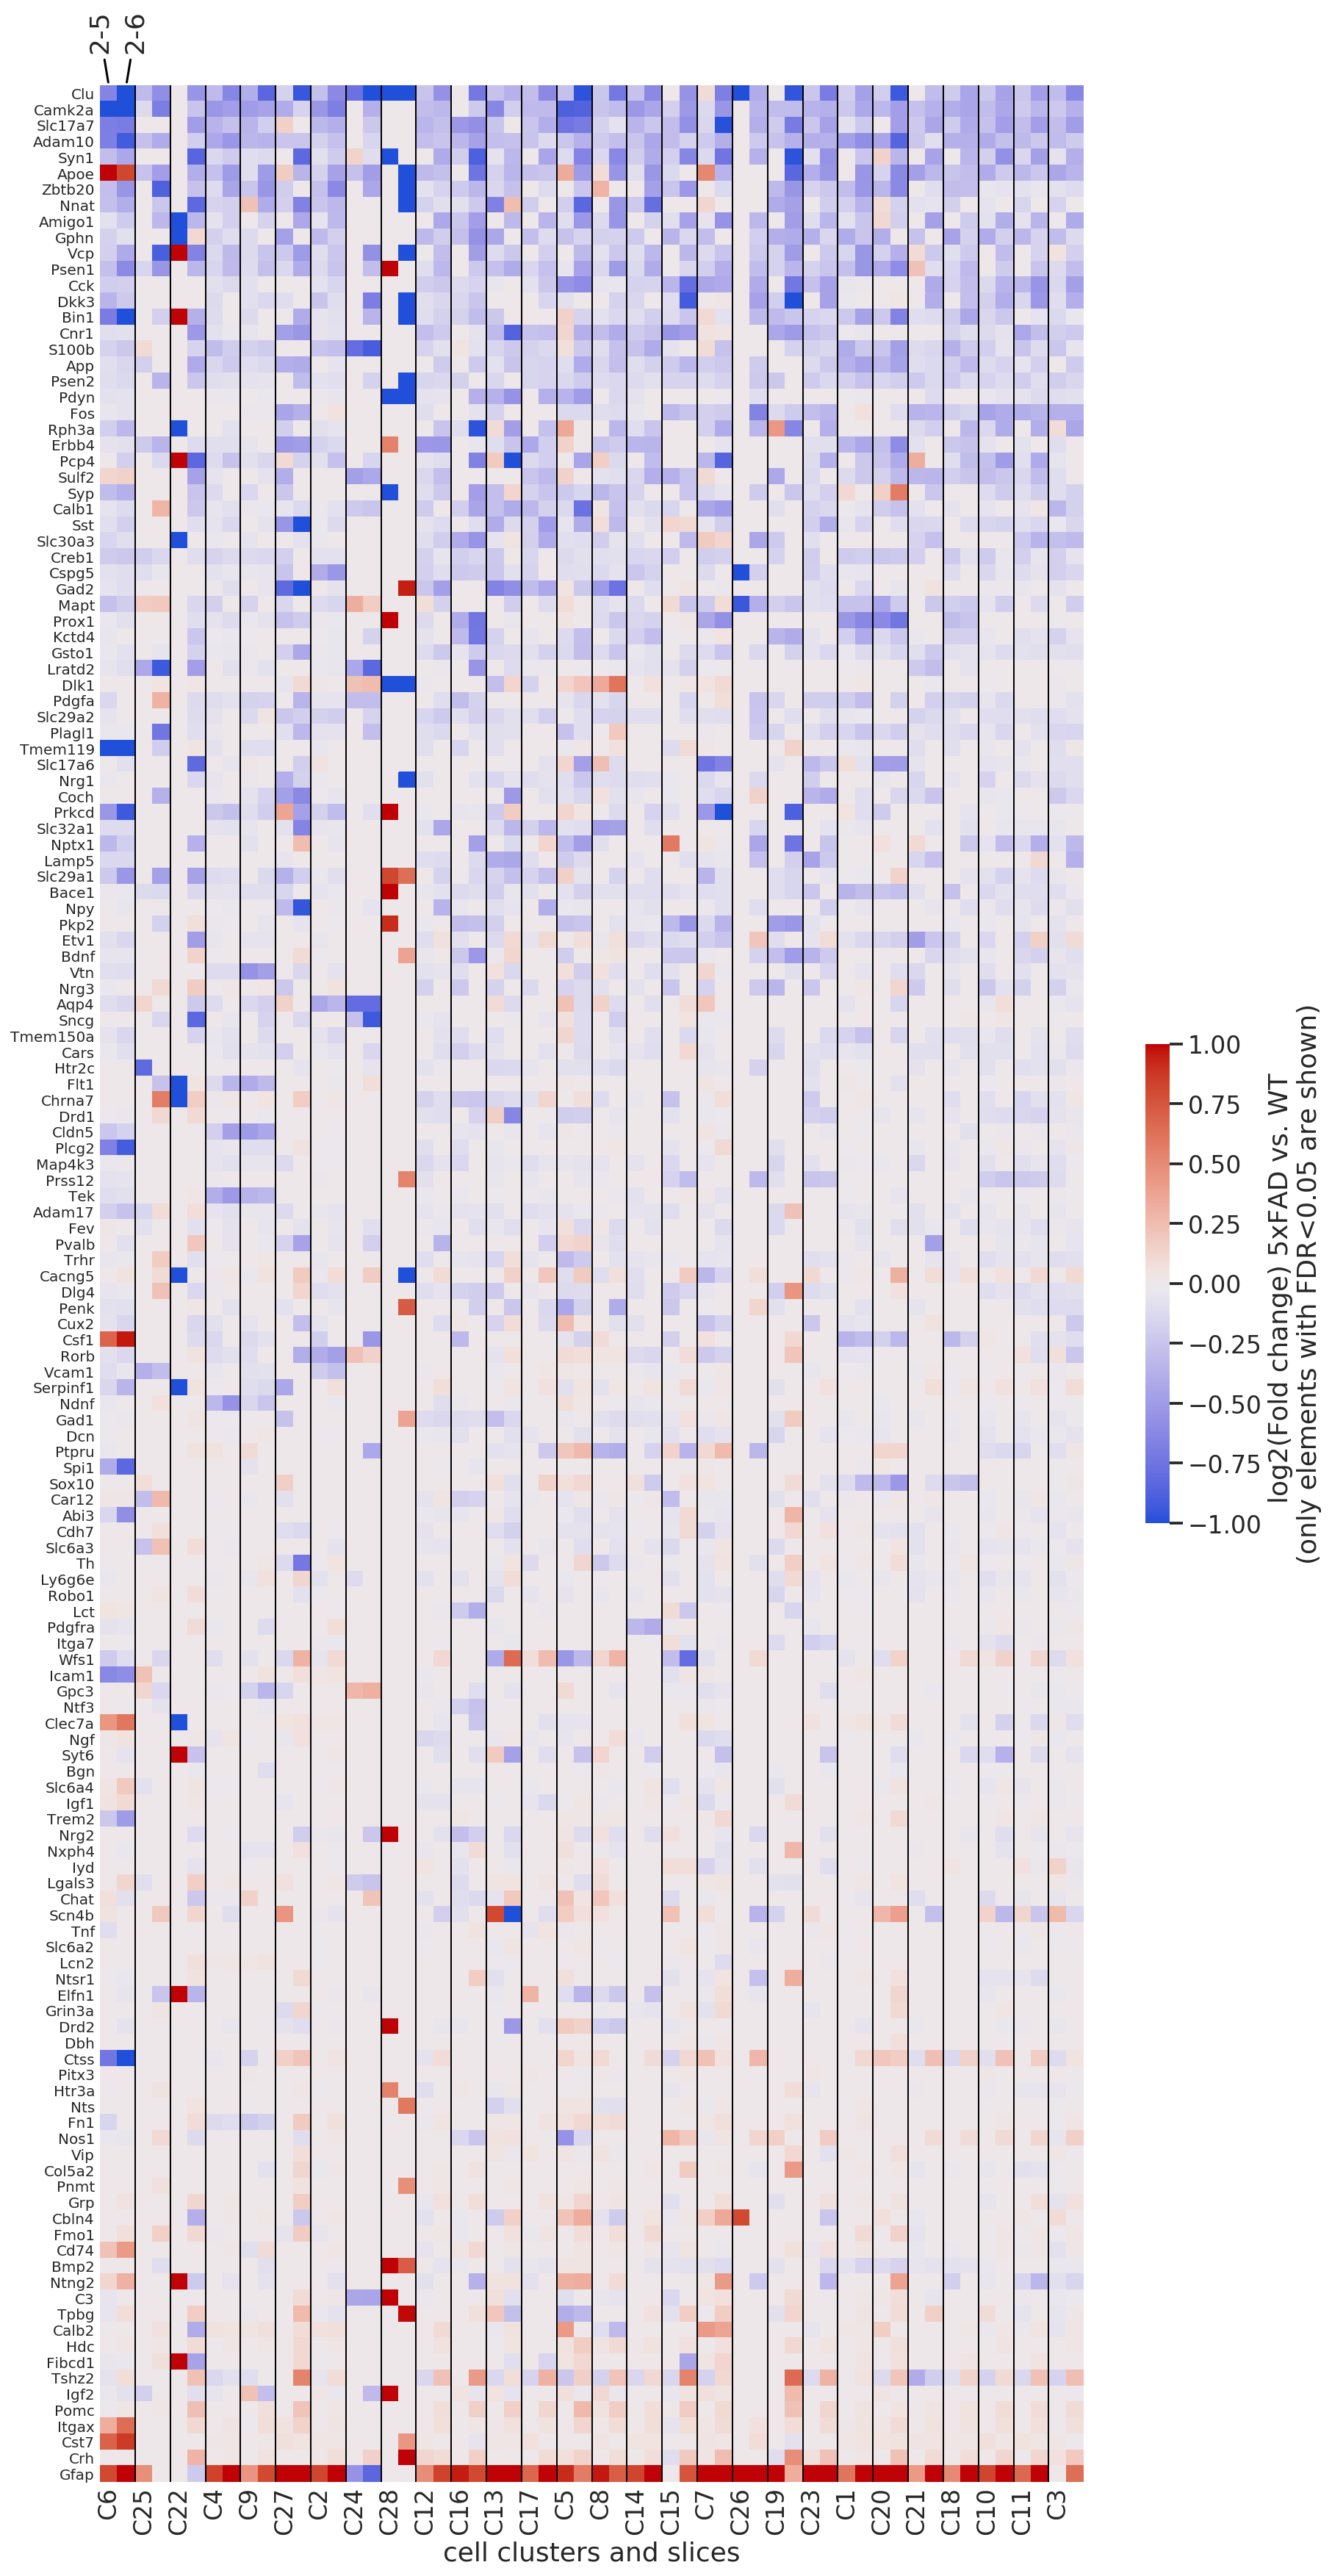

In [20]:
output = figures.format("gene_diff_5xFAD_vs_WT.pdf")

heatmat = (rejmat*diffmat).T

nrow, ncol = heatmat.shape
heatmat_reduced = heatmat.mean(level=0, axis=1)

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([2*col+np.array([0,1,]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([2*col+np.array([0,1,]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,col_order_reduced].abs().values)

_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,cluster_orders].abs().values)

# order4
colidx_v4 = np.hstack([2*col+np.array([0,1,]) for col in cluster_orders])


# order5
rowidx_v5 = np.argsort(heatmat.sum(axis=1))



fig, ax = plt.subplots(figsize=(15, 30))
sns.heatmap(
    heatmat.iloc[rowidx_v5, colidx_v4], 
#     heatmat.iloc[row_order, colidx_v4], 
#     heatmat.iloc[rowidx_v3, colidx_v4],
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
#     heatmat.iloc[rowidx_v3, col_order], 
#     heatmat,
    
    vmax=1, vmin=-1,
    center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='log2(Fold change) 5xFAD vs. WT \n(only elements with FDR<0.05 are shown)'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(2): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.set_xlabel('cell clusters and slices')
ax.vlines(np.arange(0, ncol, 2)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

../figures/2021-07-02_AD_mouse_gene_diff_hippo.pdf


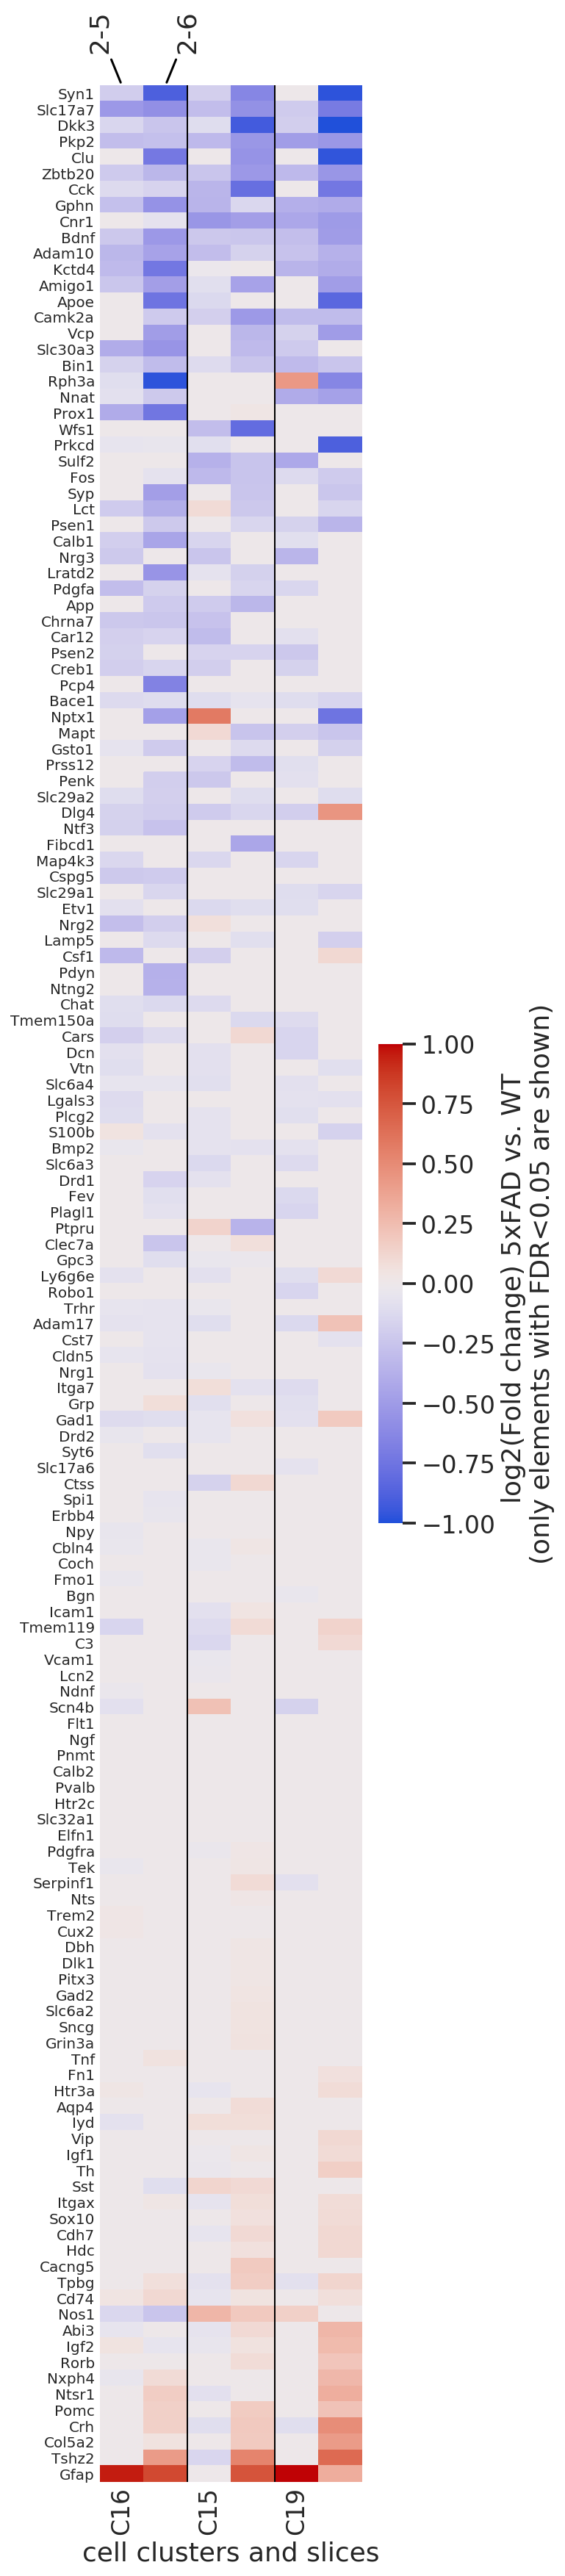

In [21]:
output = figures.format("gene_diff_hippo.pdf")

heatmat = (rejmat*diffmat).loc[selected_clusters].T

nrow, ncol = heatmat.shape
heatmat_reduced = heatmat.mean(level=0, axis=1)

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([2*col+np.array([0,1,]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([2*col+np.array([0,1,]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,col_order_reduced].abs().values)

# # order4
# colidx_v4 = np.hstack([2*col+np.array([0,1,]) for col in cluster_orders])


# order5
rowidx_v5 = np.argsort(heatmat.sum(axis=1))



fig, ax = plt.subplots(figsize=(4, 30))
sns.heatmap(
    heatmat.iloc[rowidx_v5, col_order],
#     heatmat.iloc[rowidx_v5, colidx_v4], 
#     heatmat.iloc[row_order, colidx_v4], 
#     heatmat.iloc[rowidx_v3, colidx_v4],
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
#     heatmat.iloc[rowidx_v3, col_order], 
#     heatmat,
    
    vmax=1, vmin=-1, 
    center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='log2(Fold change) 5xFAD vs. WT \n(only elements with FDR<0.05 are shown)'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(2): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.set_xlabel('cell clusters and slices')
ax.vlines(np.arange(0, ncol, 2)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()